In [84]:
# import packages
import pandas as pd
import os
import numpy as np
import seaborn as sns
import missingno as msno
import sklearn 
from plotnine import ggplot, aes, geom_line
import math

from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.ensemble import RandomForestRegressor
from skranger.ensemble import RangerForestRegressor
from sklearn.metrics import mean_squared_error

In [85]:
# Path to the folder containing the chunked data
folder_path = "../Output_datasets/Yearly_trade_data_prediction/Chunked_merged_data"

In [86]:
# List of dataframes to store the data from each file
chunks = []

In [87]:
# Loop through each file in the folder
for filename in os.listdir(folder_path):
    # Check if the file is a CSV file
    if filename.endswith(".csv"):
        # Load the file into a dataframe
        filepath = os.path.join(folder_path, filename)
        df = pd.read_csv(filepath)
        # Append the dataframe to the list
        chunks.append(df)

In [88]:
# Sanity check: concatenate all chunks, keep unique and look at number of observations
raw_data = pd.concat(chunks).drop_duplicates()
max(raw_data['Period'])

# conditionally select rows based on a condition
to_predict = raw_data ['Period'] >= 1999
selected_rows = raw_data[to_predict]
len(selected_rows)


146200

<AxesSubplot:>

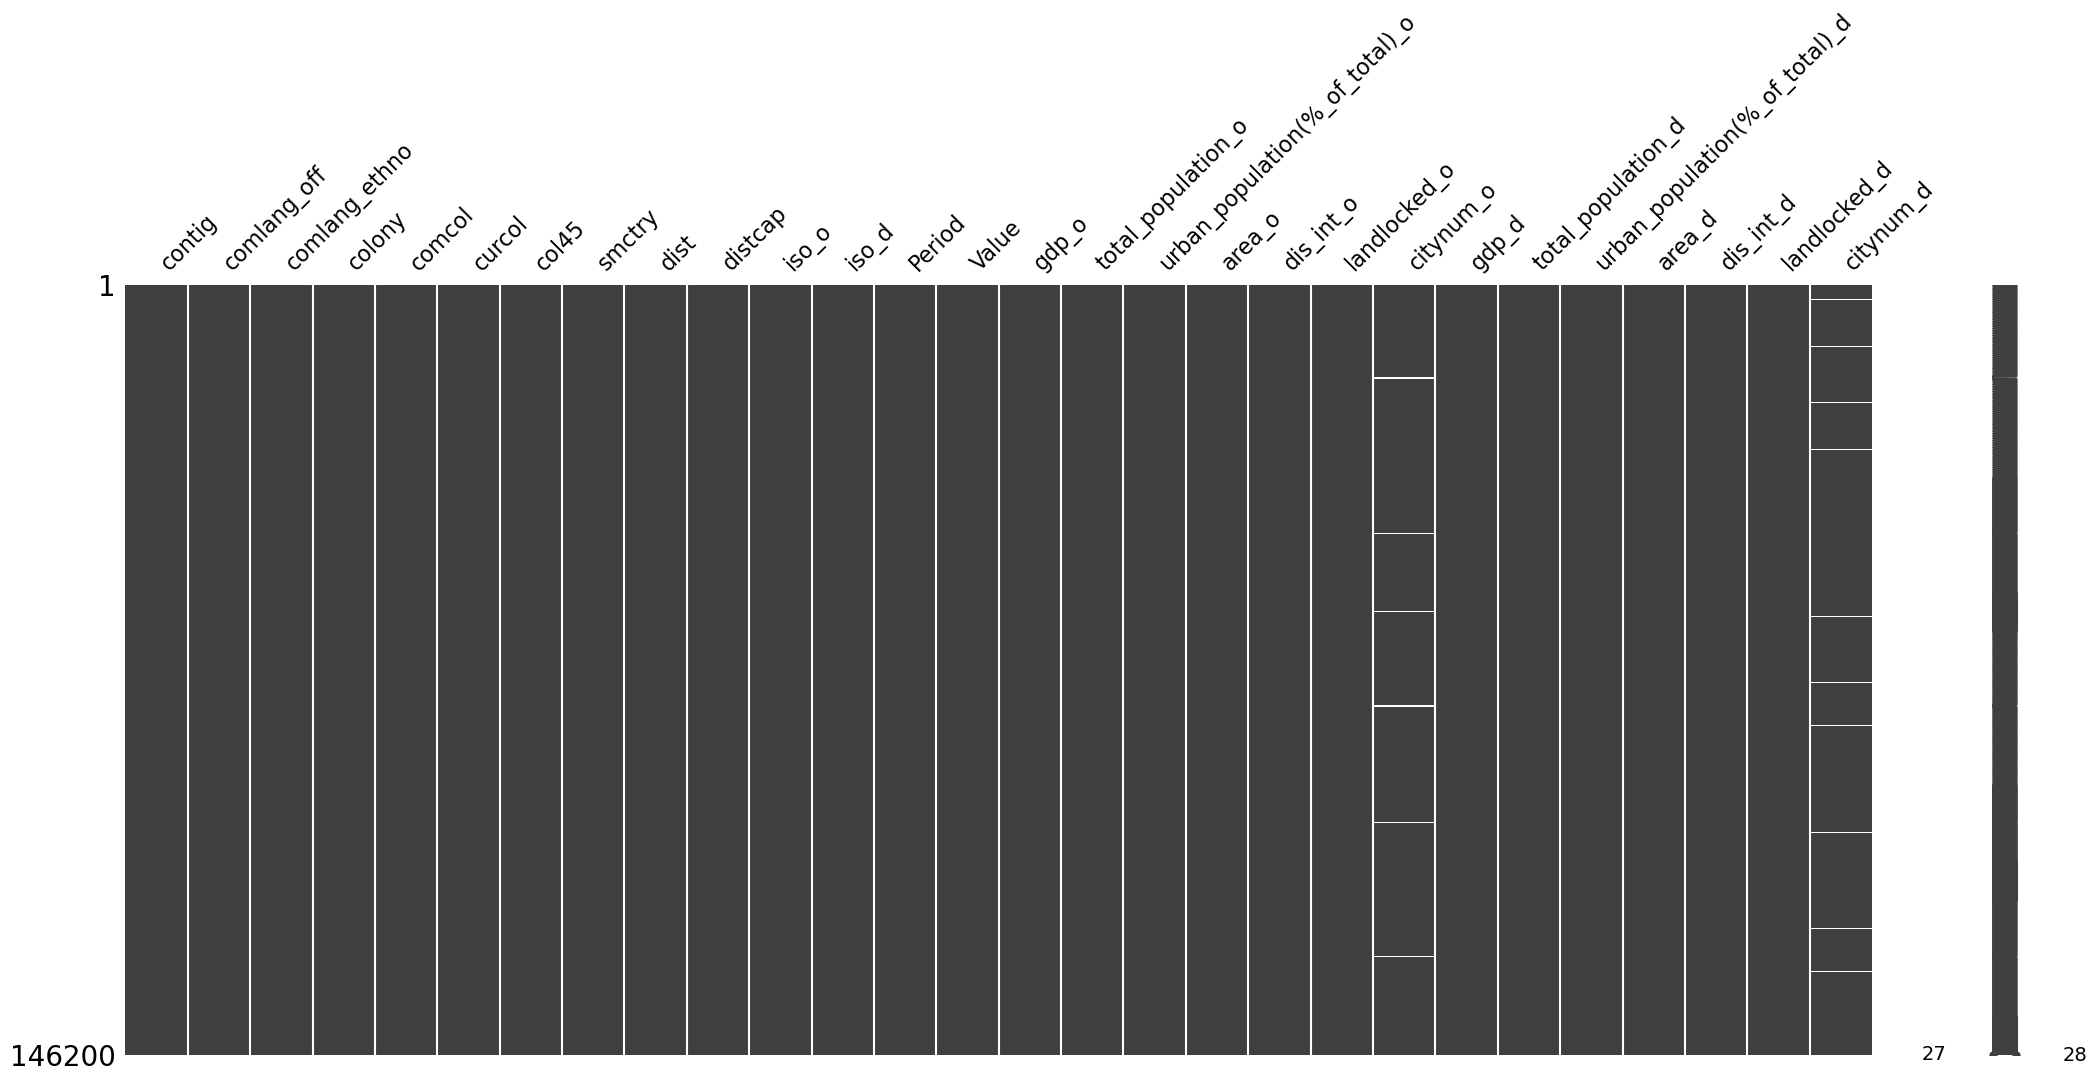

In [89]:
msno.matrix(selected_rows)

In [90]:
to_filter = selected_rows.isna().sum()
to_filter[to_filter > 0]

citynum_o    1700
citynum_d    1700
dtype: int64

In [91]:
regr = RangerForestRegressor(importance="impurity",max_depth=5, seed=42, n_jobs = -1)

tune_grid = {"mtry": [15, 20, 25], "min_node_size": [4, 7, 10]}

rf_random = GridSearchCV(
    regr,
    tune_grid,
    cv=5,
    scoring="neg_root_mean_squared_error",
    verbose=3,
)

In [99]:
data_out = pd.DataFrame()
for chunk in chunks:
    data = chunk.copy()

    # Fill missing citynum 
    data.fillna(1, inplace=True)

    # Create lagged values of trade and shift target
    data['lag_value'] = data.groupby(['iso_o', 'iso_d'])['Value'].shift(-1)
    data['Value'] = data.groupby(['iso_o', 'iso_d'])['Value'].shift(1)

    # Drop because of shifts
    data.dropna(inplace=True)
    
    year=min(data['Period'])
    data_train = data[(data["Period"] >= year) & (data["Period"] <= year + 1)]
    data_test = data[(data["Period"] == year + 2)]
    X_train= data_train.drop(['Value'], axis=1)
    X_test= data_test.drop(['Value'], axis=1)
    y_train = data_train['Value']
    y_test = data_test['Value']

    regr.fit(X_train, y_train)
    y_predic = regr.predict(X_test)

    X_test['target'] = y_test
    X_test ['prediction'] = y_predic

    data_out = pd.concat([data_out, X_test])


# calculate RMSE
rmse_lag_temporal_split = np.sqrt(mean_squared_error(y_test, y_predic))
print(np.log(rmse_lag_temporal_split))

21.6169594933477


In [100]:
data_out = pd.DataFrame()
for chunk in chunks:
    data = chunk.copy()

    # Fill missing citynum 
    data.fillna(1, inplace=True)

    # Shift target
    data['Value'] = data.groupby(['iso_o', 'iso_d'])['Value'].shift(1)

    # Drop because of shift
    data.dropna(inplace=True)
    
    year=min(data['Period'])
    data_train = data[(data["Period"] >= year) & (data["Period"] <= year + 2)]
    data_test = data[(data["Period"] == year + 3)]
    X_train= data_train.drop(['Value'], axis=1)
    X_test= data_test.drop(['Value'], axis=1)
    y_train = data_train['Value']
    y_test = data_test['Value']

    regr.fit(X_train, y_train)
    y_predic = regr.predict(X_test)

    X_test['target'] = y_test
    X_test ['prediction'] = y_predic

    data_out = pd.concat([data_out, X_test])

# calculate RMSE
rmse_nolag_temporal_split = np.sqrt(mean_squared_error(data_out['target'], data_out['prediction']))
print(np.log(rmse_nolag_temporal_split))

22.111973530062443


In [101]:
data_out = pd.DataFrame()
for chunk in chunks:
    data = chunk.copy()

    # Fill missing citynum 
    data.fillna(1, inplace=True)

    # Create lagged values of trade and shift target
    data['lag_value'] = data.groupby(['iso_o', 'iso_d'])['Value'].shift(-1)
    data['Value'] = data.groupby(['iso_o', 'iso_d'])['Value'].shift(1)

    # Drop because of shift
    data.dropna(inplace=True)
    
    # Run RF with 5 fold CV + grid search
    X = data.drop(['Value'], axis=1)
    y = data['Value']

    rf_random.fit(X, y)
    y_predic = rf_random.predict(X)

    X ['target'] = y
    X ['prediction'] = y_predic

    # Take predictions only for last year of chunk
    X = X[X['Period'] == max(X['Period'])]

    data_out = pd.concat([data_out, X])

# calculate RMSE
rmse_lag_random_split = np.sqrt(mean_squared_error(data_out['target'], data_out['prediction']))
print(np.log(rmse_lag_random_split))


Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5] END min_node_size=4, mtry=15;, score=-4497544029.028 total time=   0.4s
[CV 2/5] END min_node_size=4, mtry=15;, score=-2618581557.562 total time=   0.4s
[CV 3/5] END min_node_size=4, mtry=15;, score=-1454629932.329 total time=   0.4s
[CV 4/5] END min_node_size=4, mtry=15;, score=-1191044240.093 total time=   0.4s
[CV 5/5] END min_node_size=4, mtry=15;, score=-10579360445.032 total time=   0.4s
[CV 1/5] END min_node_size=4, mtry=20;, score=-3269358020.704 total time=   0.4s
[CV 2/5] END min_node_size=4, mtry=20;, score=-1793841560.626 total time=   0.4s
[CV 3/5] END .min_node_size=4, mtry=20;, score=-910352715.904 total time=   0.5s
[CV 4/5] END .min_node_size=4, mtry=20;, score=-838171413.087 total time=   0.4s
[CV 5/5] END min_node_size=4, mtry=20;, score=-9876428669.966 total time=   0.4s
[CV 1/5] END min_node_size=4, mtry=25;, score=-3028444781.378 total time=   0.4s
[CV 2/5] END min_node_size=4, mtry=25;, score=-2

In [102]:
    # Save results
results = pd.DataFrame({
    'year': data_out['Period'],
    'iso_o': data_out['iso_o'],
    'iso_d': data_out['iso_d'],
    'target': data_out['target'],
    'prediction': data_out['prediction']
})

results.to_csv('trade_prediction.csv')